In [1]:
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint 
import warnings
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
def preprocess_fraud_data(file_path):
    """
    Preprocess the fraud dataset and split into training and validation sets.

    Parameters:
        file_path (str): Path to the input CSV file.

    Returns:
        tuple: Processed training and validation sets (X_train, X_val, y_train, y_val) and the fitted scaler.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Convert 'trans_date_trans_time' to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Calculate age using 'dob' and transaction year
    df['transaction_year'] = df['trans_date_trans_time'].dt.year
    df['year_of_birth'] = pd.to_datetime(df['dob']).dt.year
    df['age'] = df['transaction_year'] - df['year_of_birth']
    df.drop(columns=['dob', 'transaction_year', 'year_of_birth'], inplace=True)

    # Drop irrelevant columns
    irrelevant_columns = ['Unnamed: 0', 'cc_num', 'trans_num', 'street']
    df_cleaned = df.drop(columns=irrelevant_columns)

    # Haversine function to calculate distance
    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of Earth in kilometers.
        return c * r

    # Calculate distance and add to the dataset
    df_cleaned['distance'] = df_cleaned.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

    # Create bins for latitude and longitude
    n_bins = 10
    df_cleaned['lat_bucket'] = pd.cut(df_cleaned['lat'], bins=n_bins, labels=False)
    df_cleaned['long_bucket'] = pd.cut(df_cleaned['long'], bins=n_bins, labels=False)
    df_cleaned['merch_lat_bucket'] = pd.cut(df_cleaned['merch_lat'], bins=n_bins, labels=False)
    df_cleaned['merch_long_bucket'] = pd.cut(df_cleaned['merch_long'], bins=n_bins, labels=False)

    # Encode categorical columns
    categorical_columns = ['merchant', 'category', 'gender', 'job']
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_cleaned[col] = le.fit_transform(df_cleaned[col])
        label_encoders[col] = le

    # Drop columns that are no longer needed
    columns_to_drop = ['trans_date_trans_time', 'first', 'last', 'city', 'state', 'zip', 'lat', 'long', 'merch_lat',
                         'merch_long']
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)

    # Separate features and target variable
    X = df_cleaned.drop(columns=['is_fraud'])
    y = df_cleaned['is_fraud']

    # Normalize numerical columns
    numerical_columns = ['amt', 'age', 'distance', 'lat_bucket', 'long_bucket', 'merch_lat_bucket', 'merch_long_bucket']
    scaler = StandardScaler()
    X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

    # Split into training and validation sets (fixed parameters)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_val, y_train, y_val, scaler

In [3]:
def preprocess_fraud_test(file_path, scaler):
    """
    Preprocess the fraud dataset for testing.
    
    Parameters:
        file_path (str): Path to the input CSV file.
        scaler (StandardScaler): A scaler fitted on the training data.
    
    Returns:
        tuple: Processed features and target (X, y).
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Convert 'trans_date_trans_time' to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    # Calculate age using 'dob' and transaction year
    df['transaction_year'] = df['trans_date_trans_time'].dt.year
    df['year_of_birth'] = pd.to_datetime(df['dob']).dt.year
    df['age'] = df['transaction_year'] - df['year_of_birth']
    df.drop(columns=['dob', 'transaction_year', 'year_of_birth'], inplace=True)

    # Drop irrelevant columns
    irrelevant_columns = ['Unnamed: 0', 'cc_num', 'trans_num', 'street']
    df_cleaned = df.drop(columns=irrelevant_columns)

    # Haversine function to calculate distance
    def haversine(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * asin(sqrt(a))
        r = 6371  # Radius of Earth in kilometers.
        return c * r

    # Calculate distance and add to the dataset
    df_cleaned['distance'] = df_cleaned.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

    # Create bins for latitude and longitude
    n_bins = 10
    df_cleaned['lat_bucket'] = pd.cut(df_cleaned['lat'], bins=n_bins, labels=False)
    df_cleaned['long_bucket'] = pd.cut(df_cleaned['long'], bins=n_bins, labels=False)
    df_cleaned['merch_lat_bucket'] = pd.cut(df_cleaned['merch_lat'], bins=n_bins, labels=False)
    df_cleaned['merch_long_bucket'] = pd.cut(df_cleaned['merch_long'], bins=n_bins, labels=False)

    # Encode categorical columns
    categorical_columns = ['merchant', 'category', 'gender', 'job']
    for col in categorical_columns:
        le = LabelEncoder()
        df_cleaned[col] = le.fit_transform(df_cleaned[col])

    # Drop columns that are no longer needed
    columns_to_drop = ['trans_date_trans_time', 'first', 'last', 'city', 'state', 'zip', 'lat', 'long', 'merch_lat', 'merch_long']
    df_cleaned = df_cleaned.drop(columns=columns_to_drop)

    # Separate features and target variable
    X = df_cleaned.drop(columns=['is_fraud'])
    y = df_cleaned['is_fraud']

    # Normalize numerical columns using the scaler from training
    numerical_columns = ['amt', 'age', 'distance', 'lat_bucket', 'long_bucket', 'merch_lat_bucket', 'merch_long_bucket']
    X[numerical_columns] = scaler.transform(X[numerical_columns])

    return X, y

In [4]:
# Preprocess training data
X_train, X_val, y_train, y_val, scaler = preprocess_fraud_data('fraudTrain.csv')

# Apply random oversampling to balance the training set
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Train a Random Forest classifier on the training set
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_val = rf.predict(X_val)
print("Validation Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Precision:", precision_score(y_val, y_pred_val))
print("Recall:", recall_score(y_val, y_pred_val))
print("F1 Score:", f1_score(y_val, y_pred_val))

Validation Metrics:
Accuracy: 0.9977673665336341
Precision: 0.8622016936104696
Recall: 0.7368421052631579
F1 Score: 0.7946080170273147


In [5]:
# Display feature importances
feature_scores = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_scores)

# Select features based on importance (threshold = 0.02)
selector = SelectFromModel(rf, threshold=0.02, prefit=True)
X_train_sel = selector.transform(X_train)
X_val_sel = selector.transform(X_val)
selected_features = X_train.columns[selector.get_support()]
print("Selected features based on importance:", list(selected_features))

# Ignore warning about feature names
warnings.filterwarnings("ignore", message="X has feature names, but SelectFromModel was fitted without feature names")


Feature Importances:
 amt                  0.694555
category             0.117515
unix_time            0.038736
age                  0.030250
city_pop             0.027350
job                  0.021577
merchant             0.021133
distance             0.019035
merch_long_bucket    0.006244
long_bucket          0.006181
lat_bucket           0.006030
merch_lat_bucket     0.005807
gender               0.005587
dtype: float64
Selected features based on importance: ['merchant', 'category', 'amt', 'city_pop', 'job', 'unix_time', 'age']


C:\Users\hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\hasan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [6]:
# Hyperparameter tuning using RandomizedSearchCV on selected features
param_dist = { 
    'n_estimators': randint(50, 150), 
    'max_depth': [None] + list(range(5, 15)), 
    'min_samples_split': randint(2, 6), 
    'min_samples_leaf': randint(1, 6), 
    'bootstrap': [True, False]
}

rf_tuned = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_tuned, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=2, 
    scoring='f1', 
    random_state=42, 
    n_jobs=-1
)
random_search.fit(X_train_sel, y_train)
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation F1 score:", random_search.best_score_)
best_rf = random_search.best_estimator_

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 71}
Best cross-validation F1 score: 0.9986033089472405


In [7]:
# Preprocess the test data using the fitted scaler
X_test, y_test = preprocess_fraud_test('fraudTest.csv', scaler)
X_test_sel = selector.transform(X_test)

# Evaluate the best estimator on the test set
y_test_pred = best_rf.predict(X_test_sel)
print("Test Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))

Test Metrics:
Accuracy: 0.9975635168133535
Precision: 0.6835266821345708
Recall: 0.6867132867132867
F1 Score: 0.6851162790697675


Confusion Matrix:
 [[552892    682]
 [   672   1473]]
Normalized Confusion Matrix:
 [[0.99876801 0.00123199]
 [0.31328671 0.68671329]]


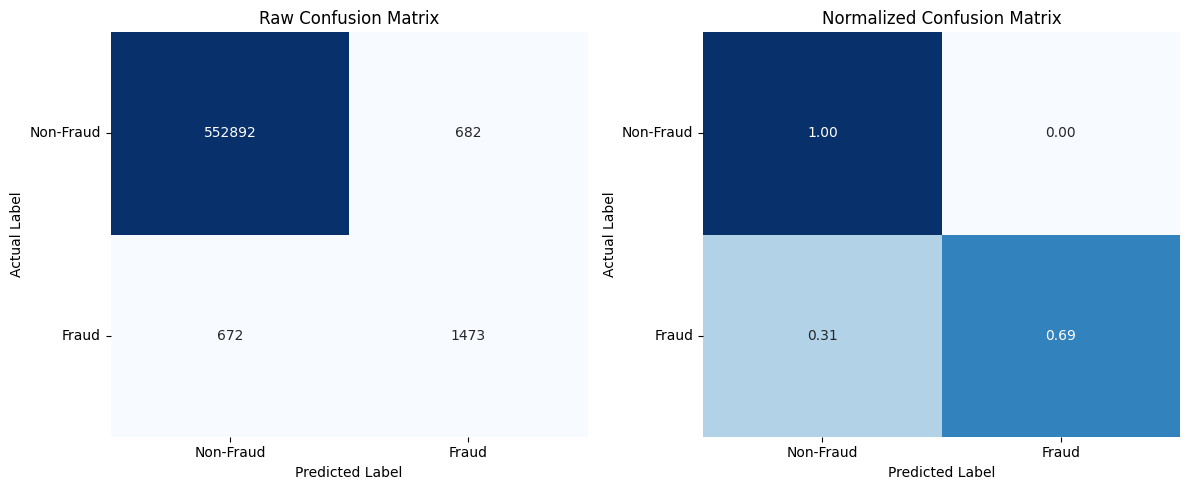

In [8]:
# Compute the confusion matrix using test labels and predictions
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

# Compute the normalized confusion matrix (row normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:\n", cm_normalized)

# Visualize both raw and normalized confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title("Raw Confusion Matrix", fontsize=12)
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
axes[0].set_yticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title("Normalized Confusion Matrix", fontsize=12)
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")
axes[1].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
axes[1].set_yticklabels(['Non-Fraud', 'Fraud'], rotation=0)

plt.tight_layout()
plt.show()

In [9]:
# Save the best model and scaler to disk
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

best_rf = joblib.load('best_rf_model.pkl')
scaler = joblib.load('scaler.pkl')

print('Loaded:', best_rf)
print('Loaded:', scaler)

Loaded: RandomForestClassifier(min_samples_leaf=4, min_samples_split=3, n_estimators=71,
                       random_state=42)
Loaded: StandardScaler()
